In [9]:

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [10]:

# Load individual Excel files with full paths
df1 = pd.read_excel('FPL_allplayers_last3_gwk_6.xlsx')
df2 = pd.read_excel('FPL_allplayers_last3_gwk_7.xlsx')
df3 = pd.read_excel('FPL_allplayers_last3_gwk_8.xlsx')



df_all = pd.concat([df1, df2, df3], ignore_index=True)

print(df_all.head())

           Player Team  Pos  GW  Minutes  Goals  Assists  BPS  Points  \
0    Aaron Hickey  BRE  DEF   4        7      0        0   -1       1   
1    Aaron Hickey  BRE  DEF   5        0      0        0    0       0   
2    Aaron Hickey  BRE  DEF   6       74      0        0    9       2   
3  Aaron Ramsdale  NEW   GK   4        0      0        0    0       0   
4  Aaron Ramsdale  NEW   GK   5        0      0        0    0       0   

   expected_goals  expected_assists  expected_goal_involvements  
0             0.0              0.00                        0.00  
1             0.0              0.00                        0.00  
2             0.0              0.03                        0.03  
3             0.0              0.00                        0.00  
4             0.0              0.00                        0.00  


In [13]:
# Create enhanced features
def create_enhanced_features(df):
    df = df.copy()
    
    # Create better feature names (matching your dataset)
    df['points_per_minute'] = df['Points'] / df['Minutes'].replace(0, 1)
    df['goal_involvement'] = df['Goals'] + df['Assists']
    df['efficiency'] = df['Points'] / (df['Minutes'] / 90).replace(0, 1)  # points per 90 mins
    
    # Form indicators
    df['recent_form'] = df.groupby('Player')['Points'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    
    # Consistency metric
    df['consistency'] = df.groupby('Player')['Points'].transform('std').fillna(0)
    
    return df

# Apply feature engineering
df_enhanced = create_enhanced_features(df_all)

In [14]:
# Analyze current player performance
def analyze_current_performance(df):
    player_stats = df.groupby(['Player', 'Team', 'Pos']).agg({
        'Points': ['sum', 'mean', 'std', 'count'],
        'Minutes': 'sum',
        'Goals': 'sum',
        'Assists': 'sum',
        'BPS': 'mean',
        'expected_goals': 'sum',
        'expected_assists': 'sum',
        'points_per_minute': 'mean',
        'goal_involvement': 'sum',
        'efficiency': 'mean',
        'recent_form': 'last',
        'consistency': 'mean',
        'GW': 'max'  # last gameweek played
    }).round(2)

    # Flatten column names
    player_stats.columns = ['_'.join(col).strip('_') for col in player_stats.columns]
    player_stats = player_stats.reset_index()
    
    # Rename for clarity
    player_stats = player_stats.rename(columns={
        'Points_sum': 'total_points',
        'Points_mean': 'avg_points',
        'Points_std': 'points_std',
        'Points_count': 'games_played',
        'Minutes_sum': 'total_minutes',
        'Goals_sum': 'total_goals',
        'Assists_sum': 'total_assists',
        'BPS_mean': 'avg_bps',
        'expected_goals_sum': 'total_xG',
        'expected_assists_sum': 'total_xA',
        'points_per_minute_mean': 'ppm',
        'goal_involvement_sum': 'total_goal_involvement',
        'efficiency_mean': 'efficiency',
        'recent_form_last': 'recent_form',
        'consistency_mean': 'consistency',
        'GW_max': 'last_gw'
    })
    
    return player_stats

current_stats = analyze_current_performance(df_enhanced)
print("Current player statistics:")
print(current_stats.head(10))

Current player statistics:
               Player Team  Pos  total_points  avg_points  points_std  \
0        Aaron Hickey  BRE  DEF            11        1.22        0.97   
1      Aaron Ramsdale  NEW   GK             0        0.00        0.00   
2        Aaron Ramsey  BUR  MID             0        0.00        0.00   
3   Aaron Wan-Bissaka  WHU  DEF             3        0.33        0.50   
4     Aarón Anselmino  CHE  DEF             0        0.00        0.00   
5       Abdallah Sima  BHA  MID             0        0.00        0.00   
6        Abdoullah Ba  SUN  MID             0        0.00        0.00   
7  Abdukodir Khusanov  MCI  DEF            10        1.11        2.62   
8          Adam Aznou  EVE  DEF             0        0.00        0.00   
9          Adam Smith  BOU  DEF             0        0.00        0.00   

   games_played  total_minutes  total_goals  total_assists  avg_bps  total_xG  \
0             9            409            0              0     3.33      0.04   
1      

In [15]:
#projection models
def project_season_totals(df, current_stats):
    """Multiple projection methods for end-of-season totals"""
    projections = []
    
    for _, player in current_stats.iterrows():
        player_name = player['Player']
        player_data = df[df['Player'] == player_name]
        games_played = player['games_played']
        
        if games_played == 0:
            continue
            
        # Method 1: Simple average projection
        simple_projection = player['avg_points'] * 38
        
        # Method 2: Recent form projection (last 3 games)
        recent_form = player_data.tail(3)['Points'].mean()
        form_projection = player['total_points'] + (recent_form * (38 - games_played))
        
        # Method 3: Efficiency-based projection (points per 90 mins)
        points_per_90 = player['efficiency']
        efficiency_projection = points_per_90 * (38 * 90 / 90)  # Assuming 90 mins per game
        
        # Method 4: Expected stats projection
        xG_contribution = (player['total_xG'] + player['total_xA']) / max(1, games_played)
        xG_projection = player['total_points'] + (xG_contribution * 4 * (38 - games_played))
        
        # Weighted average of all methods
        final_projection = np.mean([
            simple_projection, 
            form_projection, 
            efficiency_projection,
            xG_projection
        ])
        
        # Position-based adjustments
        pos = player['Pos']
        if pos == 'GK':
            final_projection *= 0.9  # Goalkeepers typically score less
        elif pos == 'DEF':
            final_projection *= 1.1  # Defenders can be valuable
        elif pos == 'FWD':
            final_projection *= 1.05  # Forwards premium
        
        projections.append({
            'player': player_name,
            'team': player['Team'],
            'position': pos,
            'games_played': games_played,
            'current_points': player['total_points'],
            'avg_points_per_game': player['avg_points'],
            'points_per_90': player['efficiency'],
            'total_goal_involvement': player['total_goal_involvement'],
            'recent_form_3_games': player['recent_form'],
            'consistency': player['consistency'],
            'projected_simple': simple_projection,
            'projected_form': form_projection,
            'projected_efficiency': efficiency_projection,
            'projected_expected': xG_projection,
            'final_projection': final_projection,
            'value_rating': final_projection / (player_data['value'].iloc[-1] if 'value' in player_data.columns else 1)
        })
    
    return pd.DataFrame(projections)

# Generate projections
season_projections = project_season_totals(df_enhanced, current_stats)
season_projections = season_projections.sort_values('final_projection', ascending=False)

print("TOP 20 PROJECTED PLAYERS:")
print("="*100)
print(season_projections.head(20).round(1).to_string(index=False))

TOP 20 PROJECTED PLAYERS:
                        player team position  games_played  current_points  avg_points_per_game  points_per_90  total_goal_involvement  recent_form_3_games  consistency  projected_simple  projected_form  projected_efficiency  projected_expected  final_projection  value_rating
                Mathias Jensen  BRE      MID             9              28                  3.1          241.2                       4                  4.3          2.8             118.2           153.7                9165.2                36.1            2368.3        2368.3
Fábio Freitas Gouveia Carvalho  BRE      MID             9              11                  1.2           96.7                       1                  0.3          2.2              46.4            20.7                3673.5                19.6             940.0         940.0
               Maxim De Cuyper  BHA      DEF             9              28                  3.1           49.6                       3         

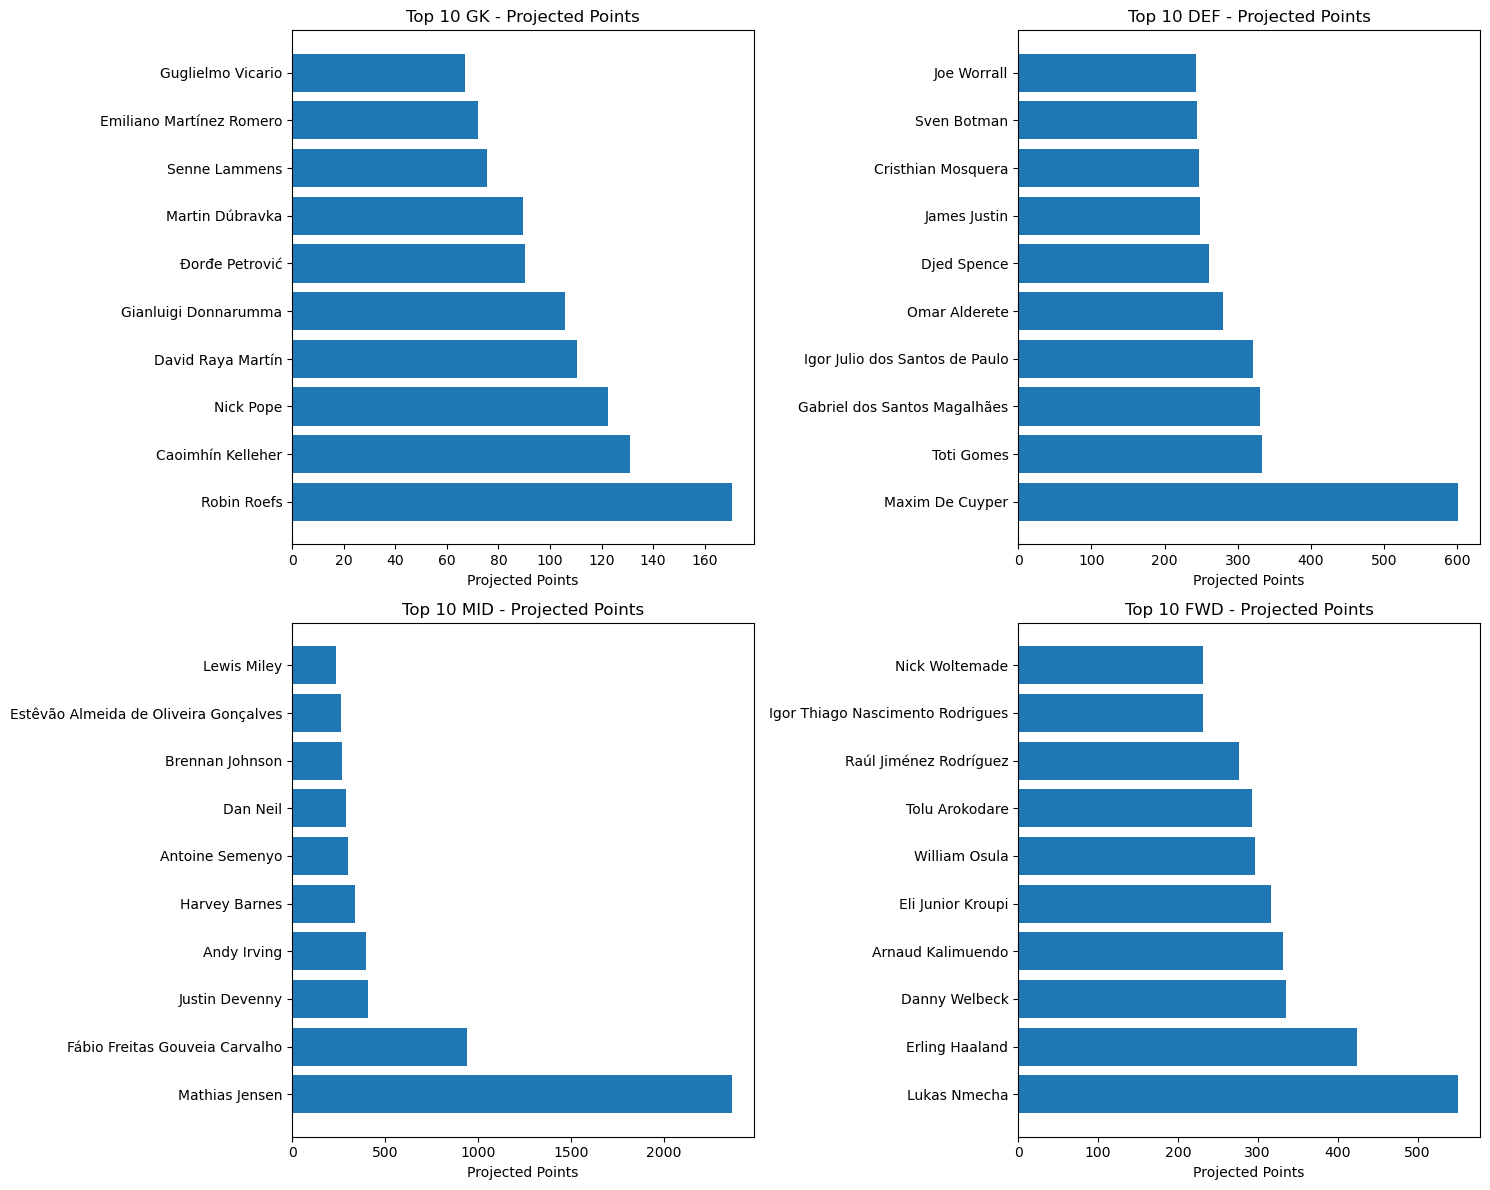


POSITION SUMMARY:
         final_projection               current_points avg_points_per_game
                     mean     max count           mean                mean
position                                                                  
DEF                  60.8   600.7   246           11.1                 1.2
FWD                  79.0   550.7    82           11.2                 1.2
GK                   17.6   170.6    86            6.1                 0.7
MID                  69.7  2368.3   331           11.1                 1.2


In [16]:
#position specific
# Analyze by position
def position_analysis(projections):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Top players by position
    for i, pos in enumerate(['GK', 'DEF', 'MID', 'FWD']):
        pos_data = projections[projections['position'] == pos].head(10)
        ax = axes[i//2, i%2]
        ax.barh(pos_data['player'], pos_data['final_projection'])
        ax.set_title(f'Top 10 {pos} - Projected Points')
        ax.set_xlabel('Projected Points')
    
    plt.tight_layout()
    plt.show()
    
    # Position summary
    pos_summary = projections.groupby('position').agg({
        'final_projection': ['mean', 'max', 'count'],
        'current_points': 'mean',
        'avg_points_per_game': 'mean'
    }).round(1)
    
    print("\nPOSITION SUMMARY:")
    print(pos_summary)

position_analysis(season_projections)

In [17]:
# Value analysis - most cost-effective players
def value_analysis(projections):
    # Add a dummy value column if not present (you should replace this with actual player values)
    if 'value' not in projections.columns:
        # This is a placeholder - you should use actual player values from your data
        projections['value'] = np.random.uniform(4.0, 12.0, len(projections))
    
    projections['points_per_million'] = projections['final_projection'] / projections['value']
    projections['value_rating'] = projections['points_per_million'] / projections['points_per_million'].max() * 100
    
    # Top value picks
    value_picks = projections.sort_values('points_per_million', ascending=False).head(15)
    
    print("\nTOP 15 VALUE PICKS (Points per Million):")
    print("="*80)
    print(value_picks[['player', 'team', 'position', 'final_projection', 'value', 'points_per_million']].round(2))
    
    return projections

season_projections = value_analysis(season_projections)


TOP 15 VALUE PICKS (Points per Million):
                             player team position  final_projection  value  \
488                  Mathias Jensen  BRE      MID           2368.30  10.49   
229  Fábio Freitas Gouveia Carvalho  BRE      MID            940.03   8.13   
502                 Maxim De Cuyper  BHA      DEF            600.70   5.32   
147                   Danny Welbeck  BHA      FWD            335.65   4.30   
57                Arnaud Kalimuendo  NFO      FWD            331.27   4.24   
273  Igor Julio dos Santos de Paulo  WHU      DEF            321.26   4.52   
442                    Lukas Nmecha  LEE      FWD            550.70   8.41   
424                     Lewis Miley  NEW      MID            236.54   4.01   
139                        Dan Neil  SUN      MID            292.05   5.00   
378                  Justin Devenny  CRY      MID            409.12   7.11   
132              Cristhian Mosquera  ARS      DEF            247.35   4.52   
233        Gabriel Mar

In [18]:
def risk_analysis(projections, df):
    """Analyze player consistency and risk"""
    consistency_metrics = []
    
    for player in projections['player'].head(30):  # Top 30 players
        player_data = df[df['Player'] == player]
        if len(player_data) > 1:
            # Consistency metrics
            points_std = player_data['Points'].std()
            zero_returns = (player_data['Points'] == 0).sum()
            consistency_score = 100 - (points_std / player_data['Points'].mean() * 100)
            
            consistency_metrics.append({
                'player': player,
                'consistency_score': max(0, consistency_score),
                'points_std': points_std,
                'zero_returns_pct': (zero_returns / len(player_data)) * 100,
                'min_points': player_data['Points'].min(),
                'max_points': player_data['Points'].max()
            })
    
    consistency_df = pd.DataFrame(consistency_metrics)
    
    # Merge with projections
    risk_analysis_df = projections.merge(consistency_df, on='player', how='left')
    
    print("\nRISK ANALYSIS - Top 20 Players:")
    print("="*90)
    risk_cols = ['player', 'position', 'final_projection', 'consistency_score', 
                 'zero_returns_pct', 'min_points', 'max_points']
    print(risk_analysis_df[risk_cols].head(20).round(1).to_string(index=False))
    
    return risk_analysis_df

risk_df = risk_analysis(season_projections, df_enhanced)



RISK ANALYSIS - Top 20 Players:
                        player position  final_projection  consistency_score  zero_returns_pct  min_points  max_points
                Mathias Jensen      MID            2368.3                9.9              22.2         0.0         6.0
Fábio Freitas Gouveia Carvalho      MID             940.0                0.0              44.4         0.0         7.0
               Maxim De Cuyper      DEF             600.7                0.0              22.2         0.0         8.0
                  Lukas Nmecha      FWD             550.7              100.0               0.0         1.0         1.0
                Erling Haaland      FWD             424.1               70.5               0.0         8.0        16.0
                Justin Devenny      MID             409.1               62.5              11.1         0.0         1.0
                   Andy Irving      MID             399.8                0.0              44.4         0.0         2.0
               

In [19]:
def generate_recommendations(projections, risk_df):
    """Generate final FPL recommendations"""
    
    # Premium picks (high projection, reliable)
    premium_picks = risk_df[
        (risk_df['final_projection'] > risk_df['final_projection'].quantile(0.8)) &
        (risk_df['consistency_score'] > 50)
    ].head(10)
    
    # Differential picks (high potential, lower ownership)
    differential_picks = risk_df[
        (risk_df['final_projection'] > risk_df['final_projection'].quantile(0.7)) &
        (risk_df['games_played'] < risk_df['games_played'].median())  # Less established
    ].head(10)
    
    # Budget enablers (good value)
    budget_picks = risk_df[
        (risk_df['points_per_million'] > risk_df['points_per_million'].quantile(0.8))
    ].head(10)
    
    print("🎯 FPL SEASON RECOMMENDATIONS")
    print("="*80)
    print("\n💎 PREMIUM PICKS (High points + Consistent):")
    print(premium_picks[['player', 'team', 'position', 'final_projection', 'consistency_score']].to_string(index=False))
    
    print("\n🚀 DIFFERENTIAL PICKS (High Potential):")
    print(differential_picks[['player', 'team', 'position', 'final_projection', 'games_played']].to_string(index=False))
    
    print("\n💰 BUDGET PICKS (Best Value):")
    print(budget_picks[['player', 'team', 'position', 'final_projection', 'points_per_million']].to_string(index=False))

generate_recommendations(season_projections, risk_df)

# Save all projections
season_projections.to_csv('/home/bankai/Downloads/archive (1)/fpl_season_projections.csv', index=False)
print(f"\n✅ Projections saved for {len(season_projections)} players!")

🎯 FPL SEASON RECOMMENDATIONS

💎 PREMIUM PICKS (High points + Consistent):
                      player team position  final_projection  consistency_score
                Lukas Nmecha  LEE      FWD        550.699917         100.000000
              Erling Haaland  MCI      FWD        424.110750          70.537217
              Justin Devenny  CRY      MID        409.121667          62.500000
Gabriel dos Santos Magalhães  ARS      DEF        330.383778          51.705931
               William Osula  NEW      FWD        297.024000         100.000000
              Tolu Arokodare  WOL      FWD        293.315167          62.500000
             Brennan Johnson  TOT      MID        265.564444         100.000000

🚀 DIFFERENTIAL PICKS (High Potential):
Empty DataFrame
Columns: [player, team, position, final_projection, games_played]
Index: []

💰 BUDGET PICKS (Best Value):
                        player team position  final_projection  points_per_million
                Mathias Jensen  BRE      